### Actividad 4.3

- Crear una visualización de datos sencilla utilizando los datos de Divvy, el sistema de bicicletas de renta de la ciudad de Chicago, datos del clima en Chicago, y la versión pública de Tableau.
- El objetivo es verificar la influencia del clima en la renta de las bicicletas para el año 2022:
- Comprobemos si las condiciones climáticas no son propicias para andar en bicicleta (e.g. frío, nieve, lluvia), el uso de las mismas es más bajo que cuando el clima se presta (e.g. verano, temperaturas agradables).

La información se obtuvo de las siguientes fuentes:

- Registros de histórico de viajes de Divvy: https://divvy-tripdata.s3.amazonaws.com/index.html
- Para los históricos de temperatura de Chicago, se utilizaron los datos disponibles en https://open-meteo.com/en/docs/historical-weather-api para el año 2022.

Los criterios para clasificar el clima son:
- 001 - frio - Temperatura < 0°C.
- 002 - lluvia - Precipitación > 0 mm y lluvia > 0 mm.
- 003 - nieve - Precipitación > 0 mm y nieve > 0 cm.
- 004 - cálido -  Temperatura entre 20°C y 30°C y humedad relativa < 60%.
- 005 - fresco - Temperatura entre 10°C y 20°C.
- 006 - soleado - Precipitación = 0 mm y nubosidad < 20%
- 007 - caluroso - Temperatura > 30°C
- 000 - nuboso


### Librerías

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd


### Carga de archivos de históricos de Divvy

In [56]:
df_total = []

#Lee los diferentes archivos
for i in range(12):
    if i < 9:
        archivo = './20220'+str(i+1)+'-divvy-tripdata.csv'
    else:
        archivo = './2022'+str(i+1)+'-divvy-tripdata.csv'
    
    print(archivo)
    df = pd.read_csv(archivo)
    df_total.append(df)

#Combina todo en un solo dataframe
df_combinado = pd.concat(df_total, ignore_index=True)

#Guarda el nuevo dataframe combinado
df_combinado.to_csv('./viajes_divvy_total.csv')


./202201-divvy-tripdata.csv
./202202-divvy-tripdata.csv
./202203-divvy-tripdata.csv
./202204-divvy-tripdata.csv
./202205-divvy-tripdata.csv
./202206-divvy-tripdata.csv
./202207-divvy-tripdata.csv
./202208-divvy-tripdata.csv
./202209-divvy-tripdata.csv
./202210-divvy-tripdata.csv
./202211-divvy-tripdata.csv
./202212-divvy-tripdata.csv


In [132]:
divvy_data = pd.read_csv('./viajes_divvy_total.csv')

In [133]:
divvy_data.columns

Index(['Unnamed: 0', 'ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [134]:
divvy_data.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


### Carga de los registros de temperatura

In [153]:
df_clima = pd.read_csv('./clima.csv')

In [154]:
df_clima.head(20)

,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),cloud_cover (%)
0,2022-01-01T00:00,4.6,97,0.0,0.0,0.00,0.03,3,100
1,2022-01-01T01:00,4.6,98,0.0,0.0,0.00,0.03,3,100
2,2022-01-01T02:00,4.7,97,0.0,0.0,0.00,0.03,3,100
3,2022-01-01T03:00,4.5,96,0.0,0.0,0.00,0.03,3,100
4,2022-01-01T04:00,4.4,94,0.0,0.0,0.00,0.02,3,100
5,2022-01-01T05:00,4.1,92,0.0,0.0,0.00,0.02,3,100
6,2022-01-01T06:00,3.9,92,0.0,0.0,0.00,0.02,3,100
7,2022-01-01T07:00,3.5,90,0.0,0.0,0.00,0.02,3,100
8,2022-01-01T08:00,3.1,89,0.0,0.0,0.00,0.02,3,100
9,2022-01-01T09:00,3.0,87,0.0,0.0,0.00,0.02,3,100


#### Se establecen los criterior para clasificar los registros

- 1 - frio - Temperatura < 5°C.
- 2 - lluvia - Precipitación > 0 mm y lluvia > 0 mm.
- 3 - nieve - Precipitación > 0 mm y nieve > 0 cm.
- 4 - cálido -  Temperatura entre 20°C y 30°C y humedad relativa < 60%.
- 5 - fresco - Temperatura entre 5°C y 20°C.
- 6 - soleado - Precipitación = 0 mm y nubosidad < 20%
- 7 - caluroso - Temperatura > 30°C y nubosidad < 20%

In [155]:
# Definimos las reglas de clasificación para cada categoría climática.
def clasificar_clima_actualizado(row):

    if row['precipitation (mm)'] > 0 and row['snowfall (cm)'] > 0:
        return 3  # nieve
    elif row['temperature_2m (°C)'] < 5:
        return 1  # frío
    elif row['precipitation (mm)'] > 0 and row['rain (mm)'] > 0:
        return 2  # lluvia
    elif 20 <= row['temperature_2m (°C)'] <= 30 and row['relative_humidity_2m (%)'] < 60:
        return 4  # cálido
    elif 10 <= row['temperature_2m (°C)'] < 20 and row['temperature_2m (°C)'] >=5 :
        return 5  # fresco
    elif row['precipitation (mm)'] == 0 and row['cloud_cover (%)'] < 20:
        return 6  # soleado
    elif row['temperature_2m (°C)'] > 30:
        return 7  # caluroso
    else:
        return 0  # nuboso



# Aplicamos la función de clasificación al dataframe.
df_clima['weather_classification'] = df_clima.apply(clasificar_clima_actualizado, axis=1)



In [156]:
df_clima.head(20)

,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),cloud_cover (%),weather_classification
0,2022-01-01T00:00,4.6,97,0.0,0.0,0.00,0.03,3,100,1
1,2022-01-01T01:00,4.6,98,0.0,0.0,0.00,0.03,3,100,1
2,2022-01-01T02:00,4.7,97,0.0,0.0,0.00,0.03,3,100,1
3,2022-01-01T03:00,4.5,96,0.0,0.0,0.00,0.03,3,100,1
4,2022-01-01T04:00,4.4,94,0.0,0.0,0.00,0.02,3,100,1
5,2022-01-01T05:00,4.1,92,0.0,0.0,0.00,0.02,3,100,1
6,2022-01-01T06:00,3.9,92,0.0,0.0,0.00,0.02,3,100,1
7,2022-01-01T07:00,3.5,90,0.0,0.0,0.00,0.02,3,100,1
8,2022-01-01T08:00,3.1,89,0.0,0.0,0.00,0.02,3,100,1
9,2022-01-01T09:00,3.0,87,0.0,0.0,0.00,0.02,3,100,1


In [157]:
df_clima.describe()

,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),cloud_cover (%),weather_classification
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.00000
mean,10.007797,72.106393,0.127557,0.115525,0.008438,0.016734,9.613927,46.068265,2.65742
std,11.707358,16.002243,0.662194,0.656304,0.065958,0.037012,20.534579,39.033010,2.12963
min,-24.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.100000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.00000
50%,10.700000,74.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34.000000,2.00000
75%,20.200000,85.000000,0.000000,0.000000,0.000000,0.010000,3.000000,90.000000,5.00000
max,37.400000,100.000000,19.300000,19.300000,1.890000,0.170000,75.000000,100.000000,7.00000


In [158]:
#Se guarda el nuevo dataframe del clima clasificado
df_clima.to_csv('./clima_clasificado.csv', index=False)

#### Se realiza la corrección del formato de fechas de ambos dataframes

In [159]:
#Se carga el nuevo archivo CSV
clima_clasificado_data = pd.read_csv('./clima_clasificado.csv')

#Se convierte la columna de tiempo a datetime
clima_clasificado_data['time'] = pd.to_datetime(clima_clasificado_data['time'])

#Se muestran las primeras filas
clima_clasificado_data_head = clima_clasificado_data.head()
clima_clasificado_data_info = clima_clasificado_data.info()

clima_clasificado_data_head, clima_clasificado_data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   time                      8760 non-null   datetime64[ns]
 1   temperature_2m (°C)       8760 non-null   float64       
 2   relative_humidity_2m (%)  8760 non-null   int64         
 3   precipitation (mm)        8760 non-null   float64       
 4   rain (mm)                 8760 non-null   float64       
 5   snowfall (cm)             8760 non-null   float64       
 6   snow_depth (m)            8760 non-null   float64       
 7   weather_code (wmo code)   8760 non-null   int64         
 8   cloud_cover (%)           8760 non-null   int64         
 9   weather_classification    8760 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 684.5 KB


(                 time  temperature_2m (°C)  relative_humidity_2m (%)  \
 0 2022-01-01 00:00:00                  4.6                        97   
 1 2022-01-01 01:00:00                  4.6                        98   
 2 2022-01-01 02:00:00                  4.7                        97   
 3 2022-01-01 03:00:00                  4.5                        96   
 4 2022-01-01 04:00:00                  4.4                        94   
 
    precipitation (mm)  rain (mm)  snowfall (cm)  snow_depth (m)  \
 0                 0.0        0.0            0.0            0.03   
 1                 0.0        0.0            0.0            0.03   
 2                 0.0        0.0            0.0            0.03   
 3                 0.0        0.0            0.0            0.03   
 4                 0.0        0.0            0.0            0.02   
 
    weather_code (wmo code)  cloud_cover (%)  weather_classification  
 0                        3              100                       1  
 1      

#### Para relacionar los datos de Divvy con los del clima, se procederá a redondear los tiempos de inicio del viaje

In [160]:
#Se verifica primero el tipo de dato de la columna 'started_at'
print(divvy_data['started_at'].dtype)

#En caso de requerir se convierte a datetime
if divvy_data['started_at'].dtype != 'datetime64[ns]':
    divvy_data['started_at'] = pd.to_datetime(divvy_data['started_at'])

#Se redondea el valor de fecha
divvy_data['started_at_rounded'] = divvy_data['started_at'].dt.round('H')

#Primeras filas con resultado
divvy_data[['started_at', 'started_at_rounded']].head()


datetime64[ns]


,started_at,started_at_rounded
0,2022-01-13 11:59:47,2022-01-13 12:00:00
1,2022-01-10 08:41:56,2022-01-10 09:00:00
2,2022-01-25 04:53:40,2022-01-25 05:00:00
3,2022-01-04 00:18:04,2022-01-04 00:00:00
4,2022-01-20 01:31:10,2022-01-20 02:00:00


In [161]:
#Se redonde el valor de fecha en los registros de Divvy
divvy_data['started_at_rounded'] = divvy_data['started_at'].dt.round('H')

#Se unen los datos de clima y registros de Divvy
combined_data = pd.merge(left=divvy_data, right=clima_clasificado_data, 
                         left_on='started_at_rounded', right_on='time', 
                         how='inner')

#Primeras filas del resultado
combined_data.head()


,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,time,temperature_2m (°C),relative_humidity_2m (%),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),cloud_cover (%),weather_classification
0,0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,...,2022-01-13 12:00:00,0.8,93,0.0,0.0,0.0,0.07,3,100,1
1,84,36EE576E7B20FF47,classic_bike,2022-01-13 12:10:56,2022-01-13 12:26:51,Michigan Ave & 14th St,TA1307000124,Clinton St & Washington Blvd,WL-012,41.864059,...,2022-01-13 12:00:00,0.8,93,0.0,0.0,0.0,0.07,3,100,1
2,268,1E8AEC8448139702,classic_bike,2022-01-13 11:33:59,2022-01-13 11:42:06,St. Clair St & Erie St,13016,Columbus Dr & Randolph St,13263,41.894345,...,2022-01-13 12:00:00,0.8,93,0.0,0.0,0.0,0.07,3,100,1
3,354,49FD38994D96D310,classic_bike,2022-01-13 12:10:30,2022-01-13 12:16:27,Wilton Ave & Diversey Pkwy,TA1306000014,Sheffield Ave & Webster Ave,TA1309000033,41.932418,...,2022-01-13 12:00:00,0.8,93,0.0,0.0,0.0,0.07,3,100,1
4,428,6942BBE7564519EB,classic_bike,2022-01-13 11:52:48,2022-01-13 12:07:26,Carpenter St & Huron St,13196,LaSalle St & Adams St,KA1503000034,41.894556,...,2022-01-13 12:00:00,0.8,93,0.0,0.0,0.0,0.07,3,100,1


### Inicia el análisis del impacto del clima en los viajes

In [162]:
#Revisamos estadísticas de número de viajes por categoría del clima

#Número de viajes de bicicleta en cada categoría climática
trips_by_weather = combined_data.groupby('weather_classification')['ride_id'].count().reset_index()

#Se ajustan los nombres de columnas
trips_by_weather.columns = ['Weather Classification', 'Number of Trips']

# Mostrar el resultado
trips_by_weather


,Weather Classification,Number of Trips
0,0,988122
1,1,753359
2,2,597318
3,3,41177
4,4,880918
5,5,1510609
6,6,822404
7,7,73713


### Visualizaciones del análisis

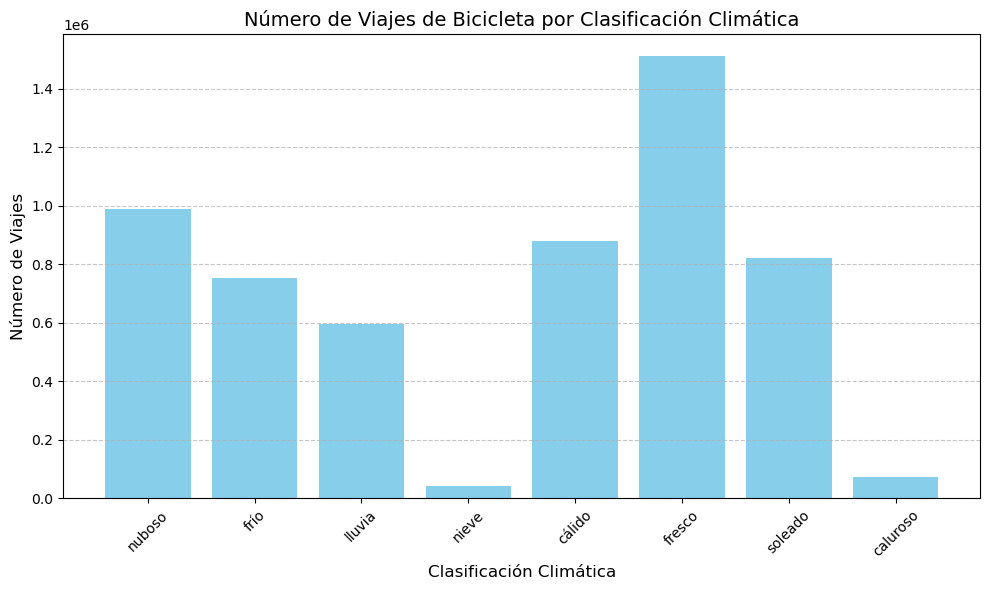

In [163]:
#Diccionario de mapeo de códigos de clasificación climática a descripciones
weather_classification_descriptions = {
    0: 'nuboso',
    1: 'frío',
    2: 'lluvia',
    3: 'nieve',
    4: 'cálido',
    5: 'fresco',
    6: 'soleado',
    7: 'caluroso'
}

#Aplica las descripciones a la columna 'Weather Classification'
trips_by_weather['Weather Description'] = trips_by_weather['Weather Classification'].map(weather_classification_descriptions)

#Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(trips_by_weather['Weather Description'], trips_by_weather['Number of Trips'], color='skyblue')
plt.title('Número de Viajes de Bicicleta por Clasificación Climática', fontsize=14)
plt.xlabel('Clasificación Climática', fontsize=12)
plt.ylabel('Número de Viajes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [164]:
leyendas = {
    0: 'Días nubosos',
    1: 'Días fríos',
    2: 'Días con lluvia',
    3: 'Días con nieve',
    4: 'Días cálidos',
    5: 'Días frescos',
    6: 'Días soleados',
    7: 'Días calurosos'
}

def analisis_por_tipo_clima(weather_category_code):
    #Crear una serie de tiempo para la categoría específica por día
    daily_weather_specific = combined_data[combined_data['weather_classification'] == weather_category_code] \
                                .groupby(combined_data['time'].dt.date)['weather_classification'].count()

    #Prepara el dataframe para la visualización
    daily_data_specific = pd.DataFrame({
        'Total Viajes': daily_trips,
        'Datos': daily_weather_specific
    }).fillna(0)

    #Crea la gráfica
    fig, ax1 = plt.subplots(figsize=(20, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Viajes', color=color, fontsize=20)
    ax1.plot(daily_data_specific.index, daily_data_specific['Total Viajes'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(leyendas[weather_category_code], color=color, fontsize=20) 
    ax2.plot(daily_data_specific.index, daily_data_specific['Datos'], color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título y mostrar gráfico
    plt.title('Total de viajes vs '+leyendas[weather_category_code], fontsize=20)
    fig.tight_layout()
    plt.show()


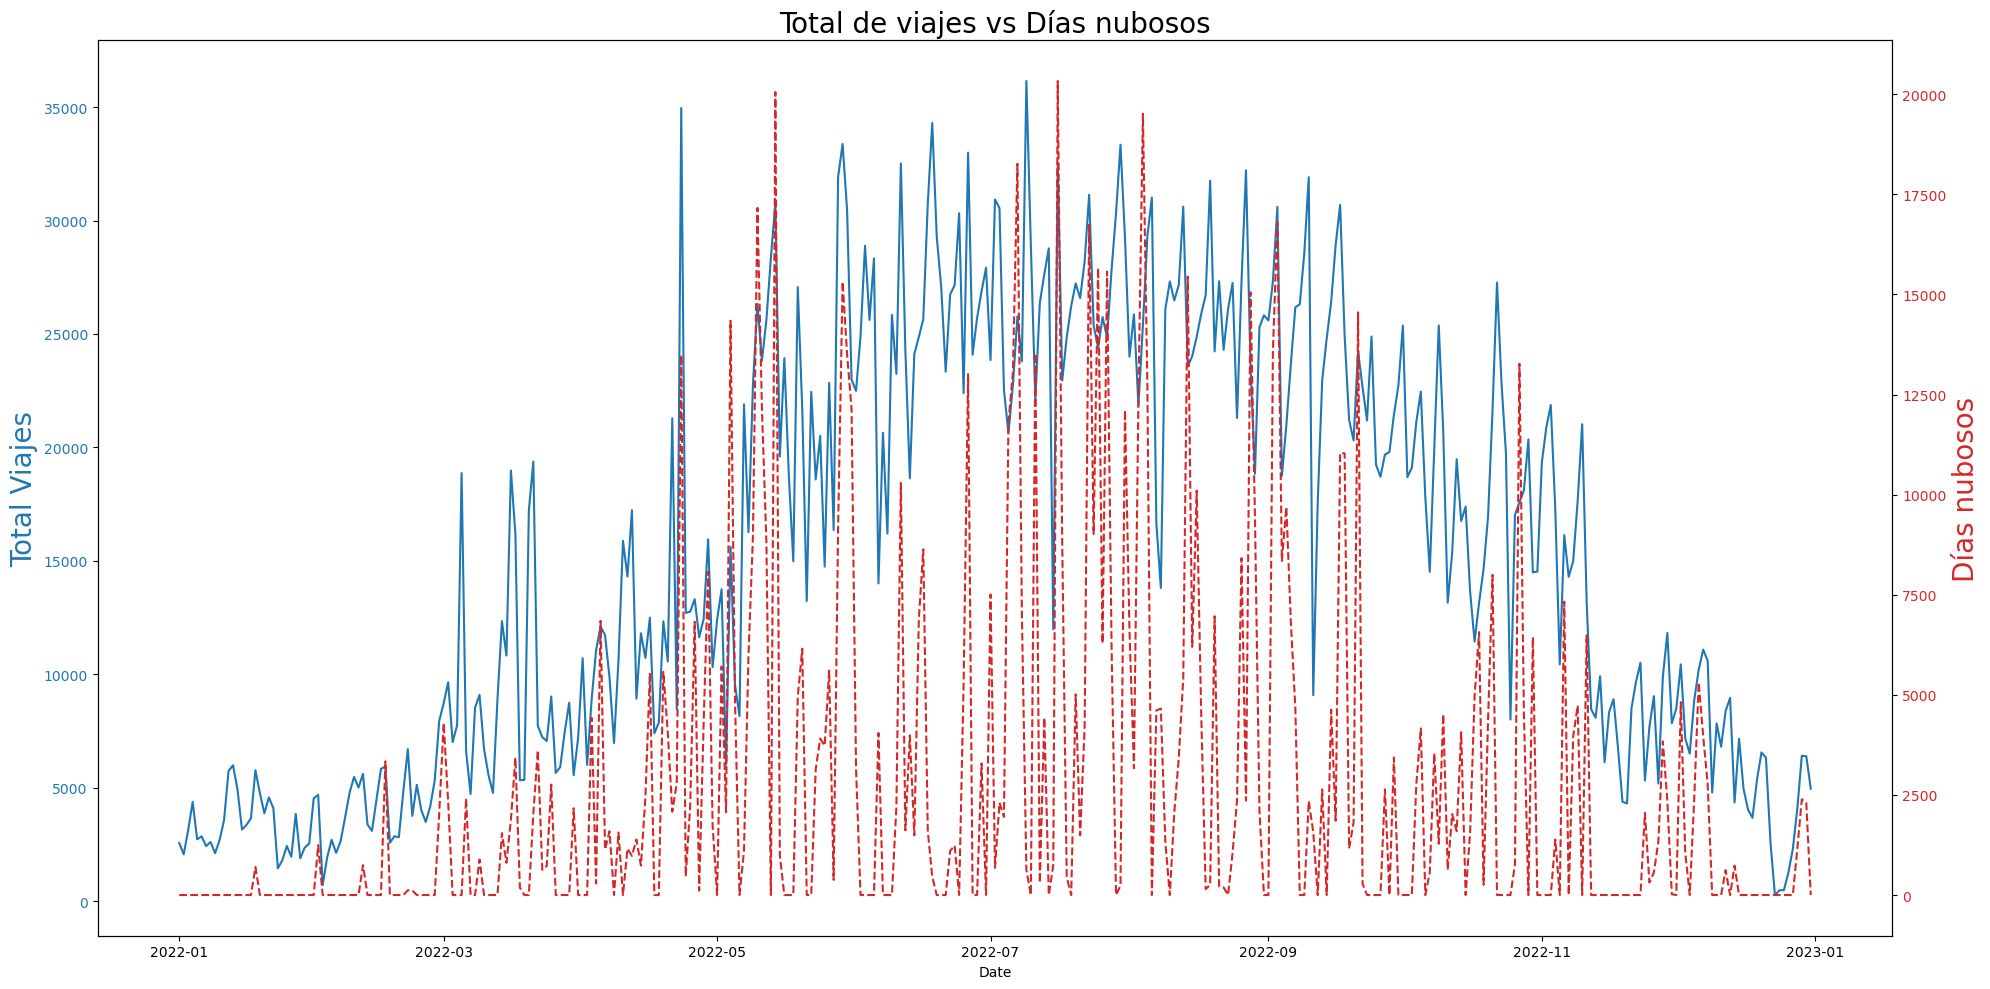

In [165]:
analisis_por_tipo_clima(0)

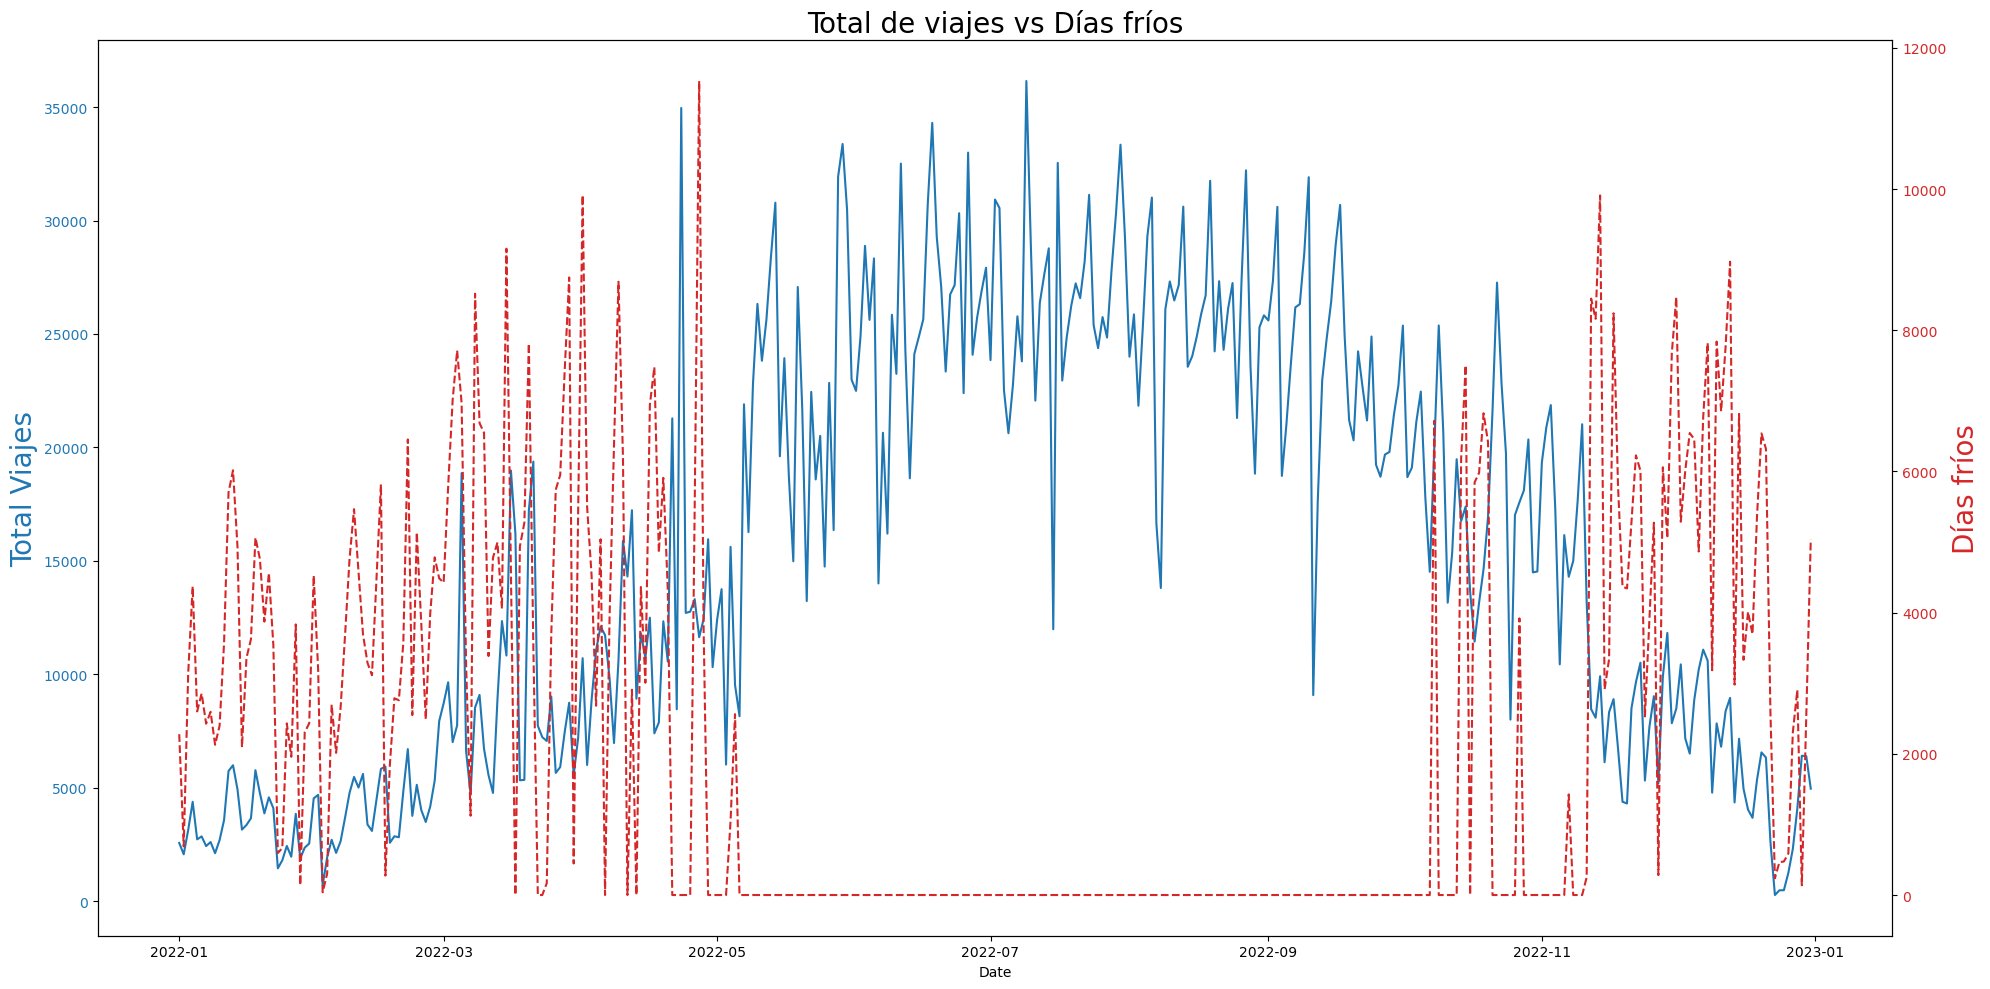

In [166]:
analisis_por_tipo_clima(1)

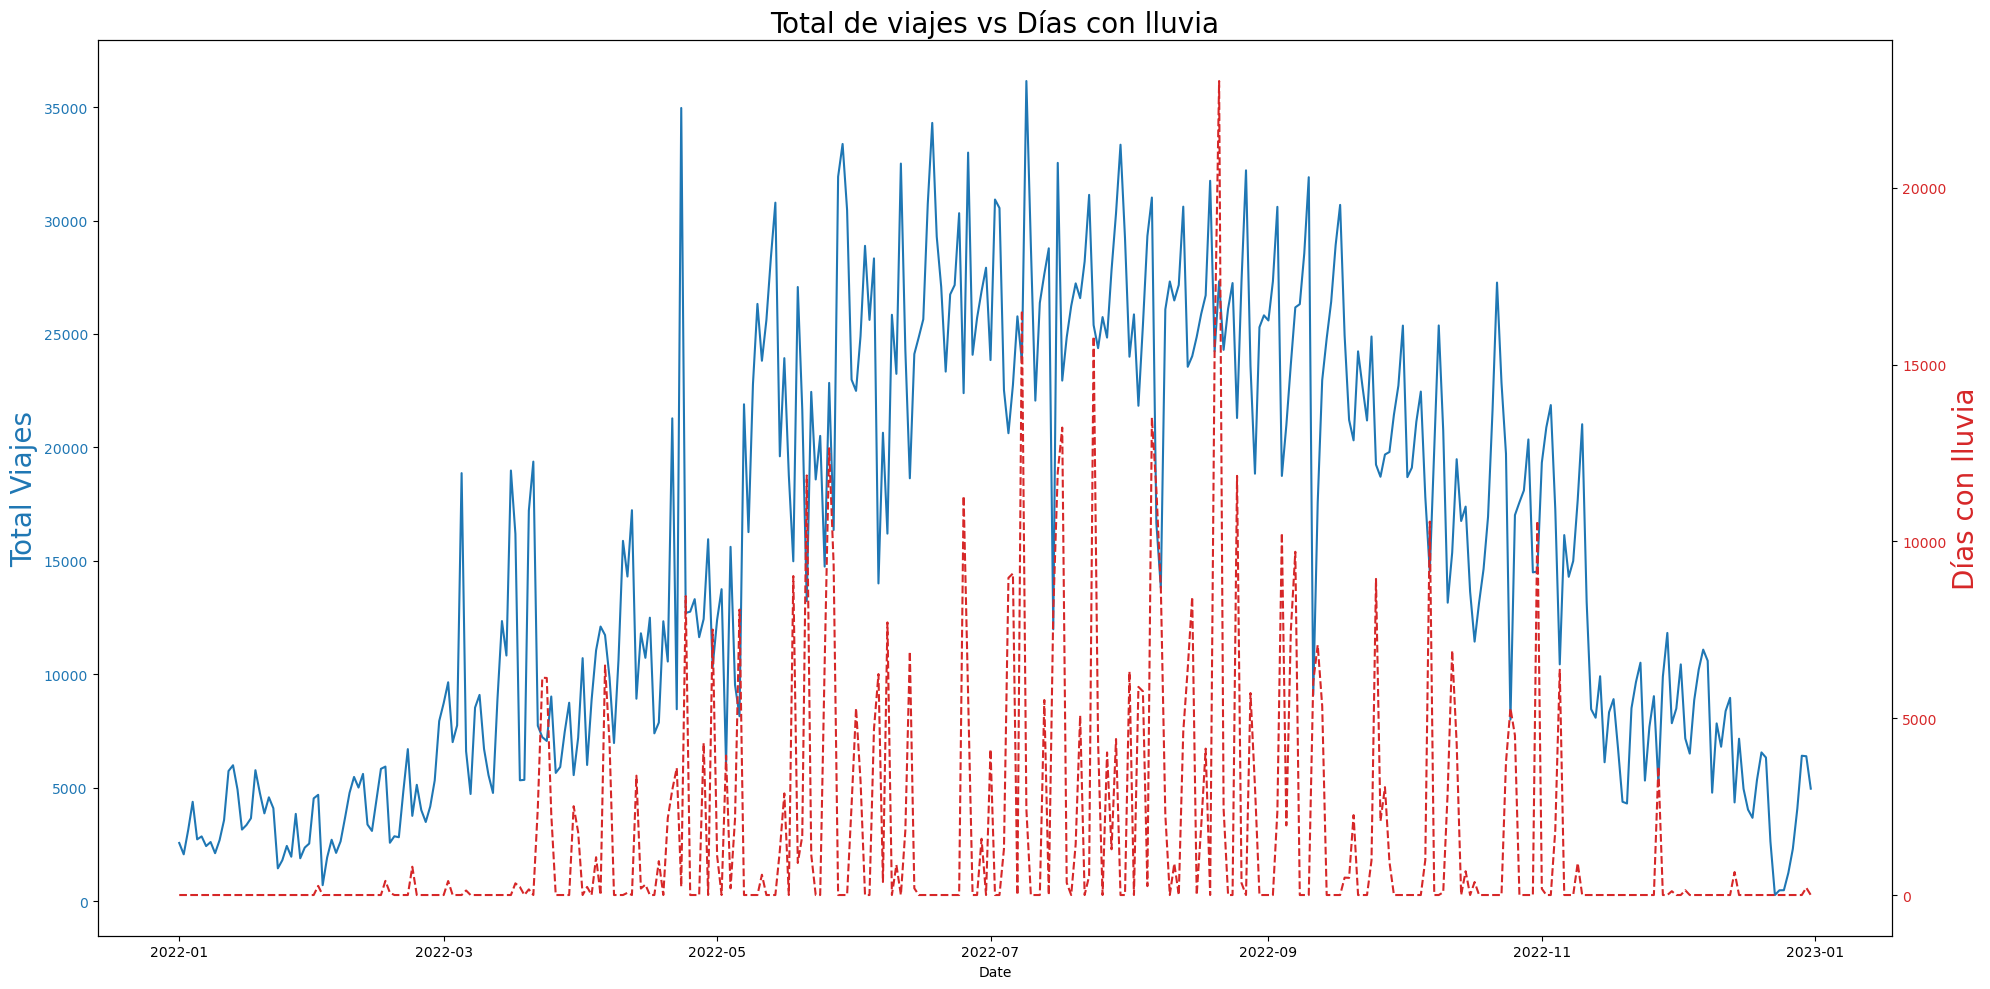

In [167]:
analisis_por_tipo_clima(2)

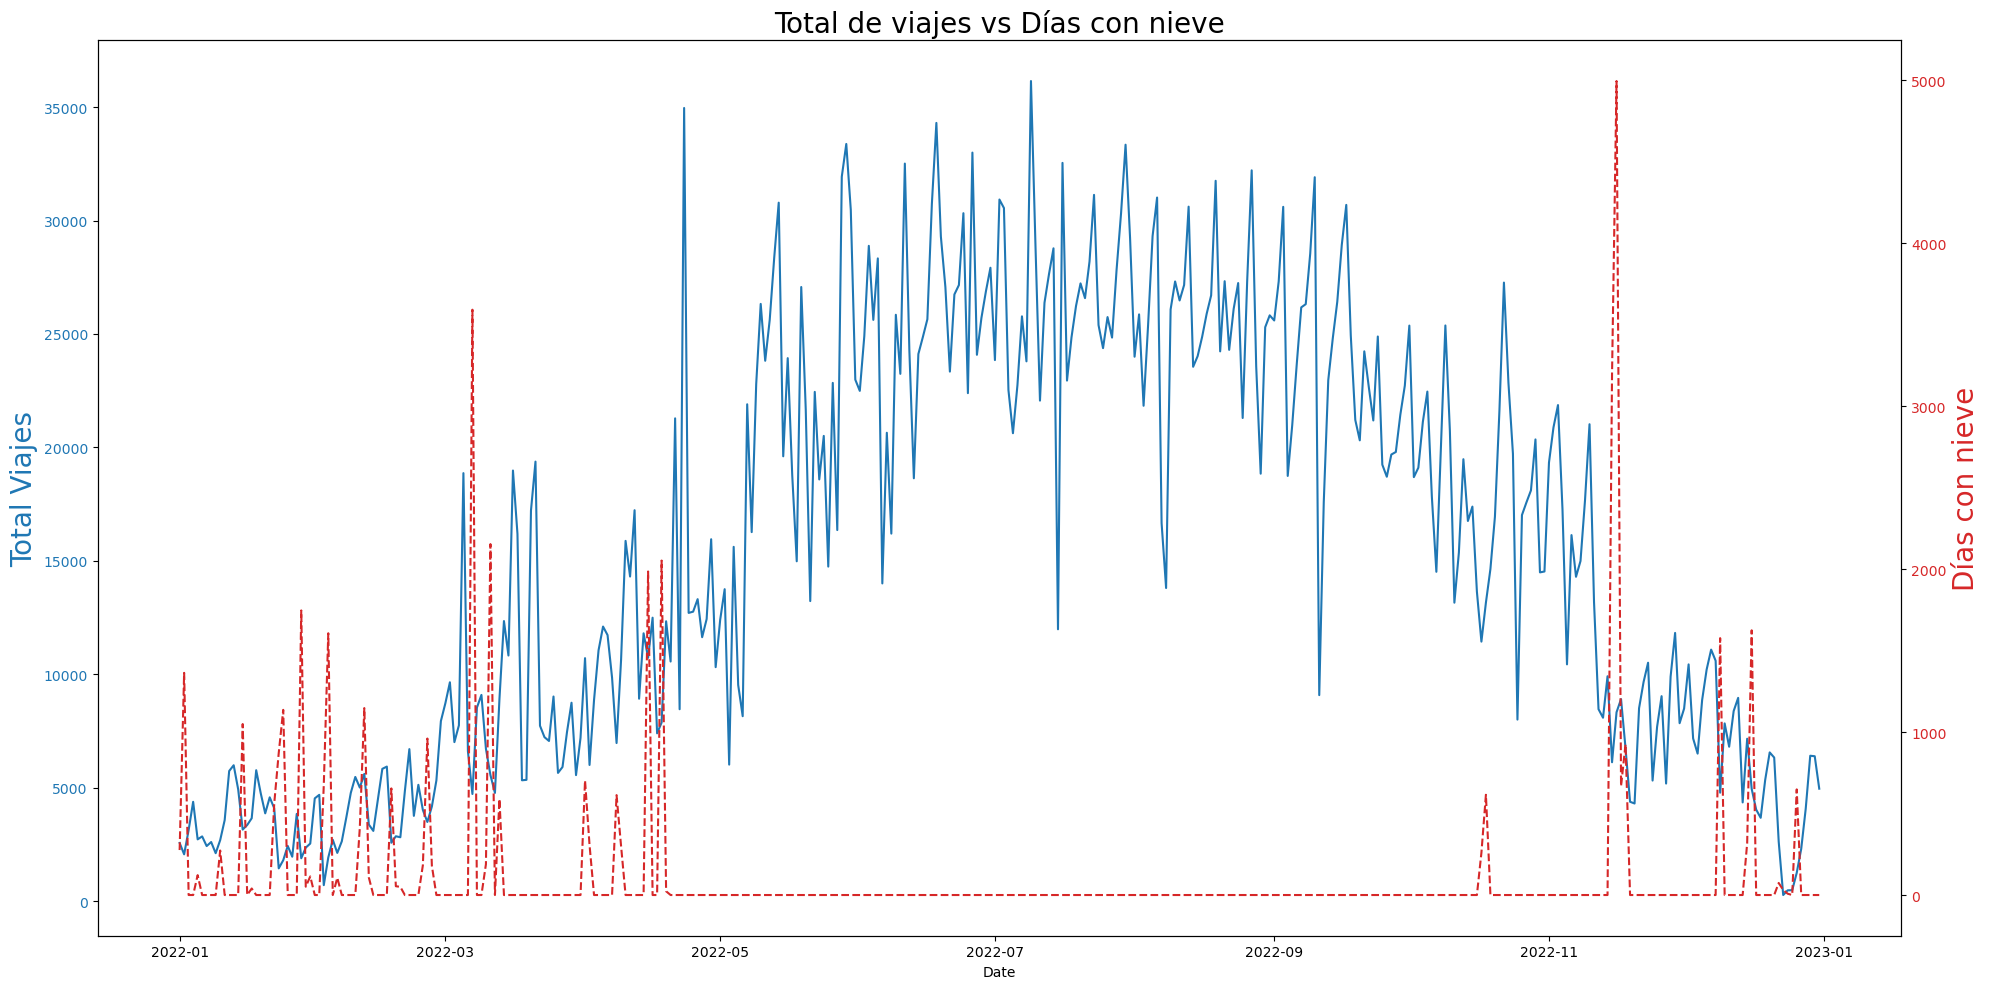

In [168]:
analisis_por_tipo_clima(3)

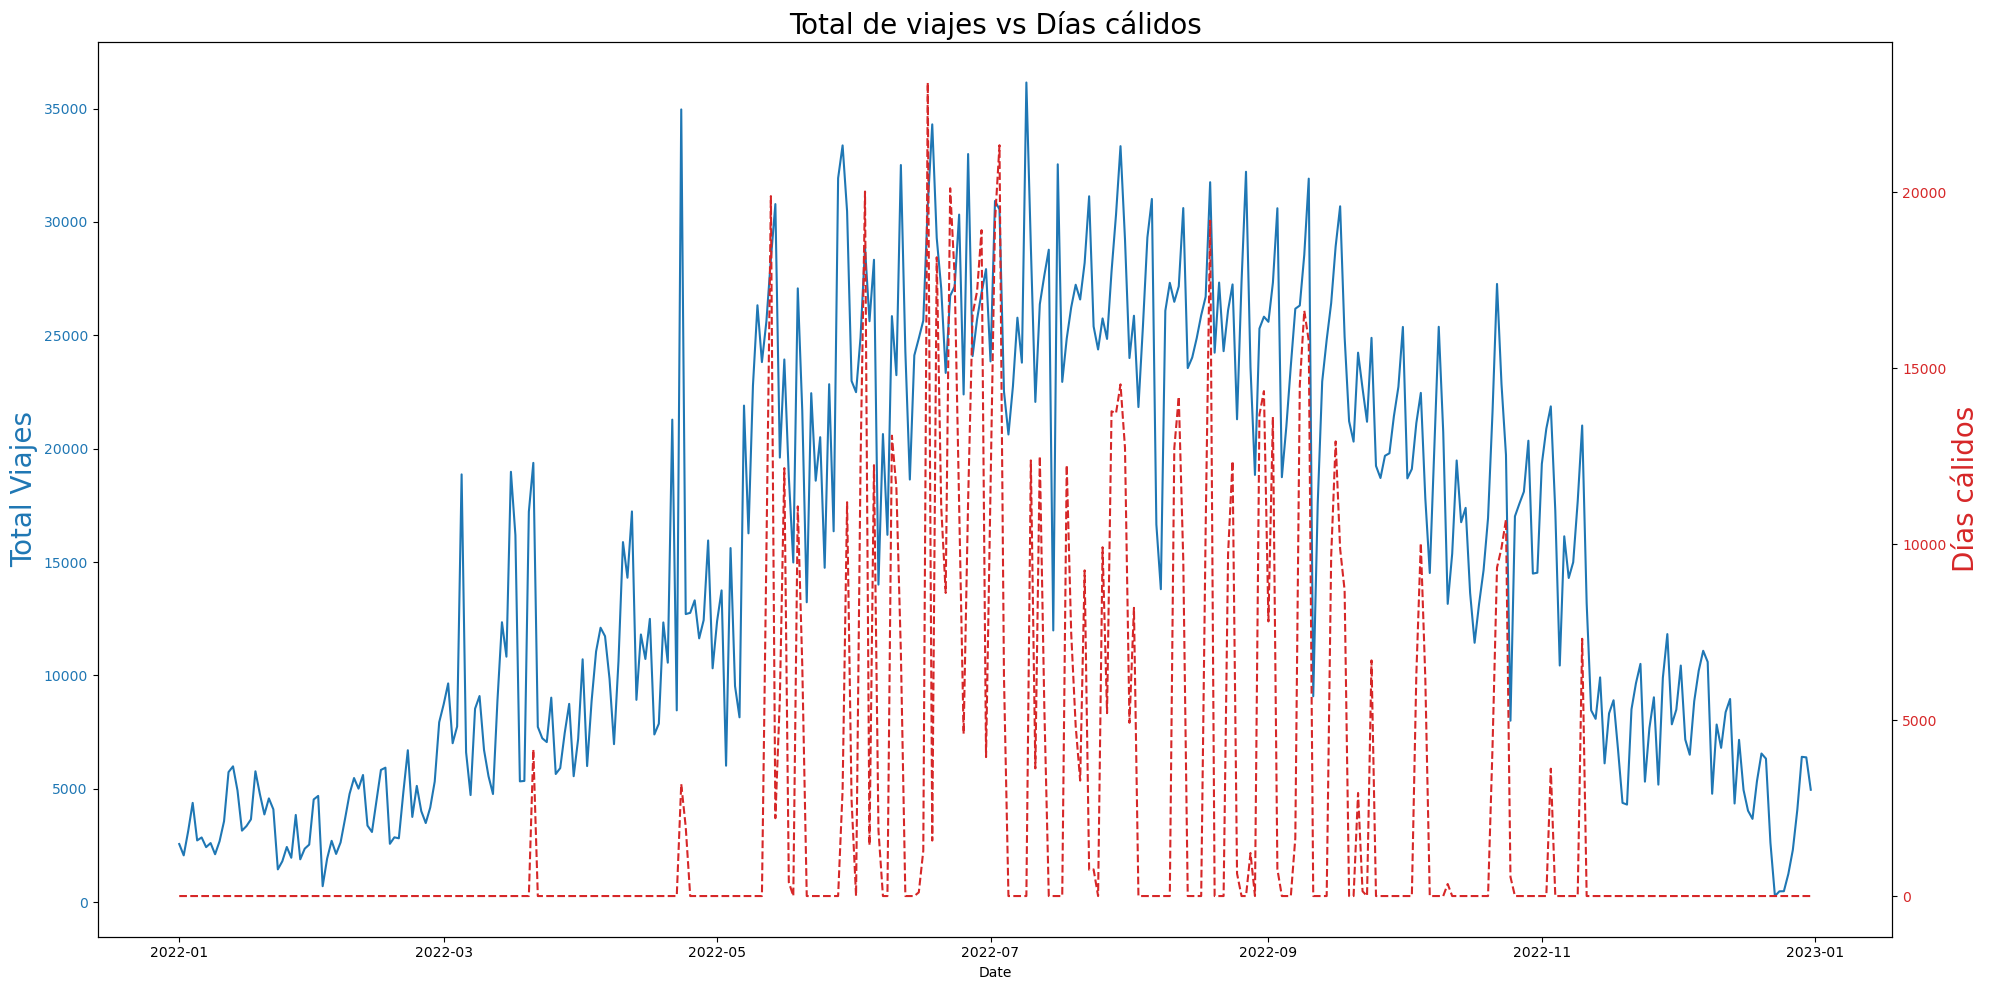

In [169]:
analisis_por_tipo_clima(4)

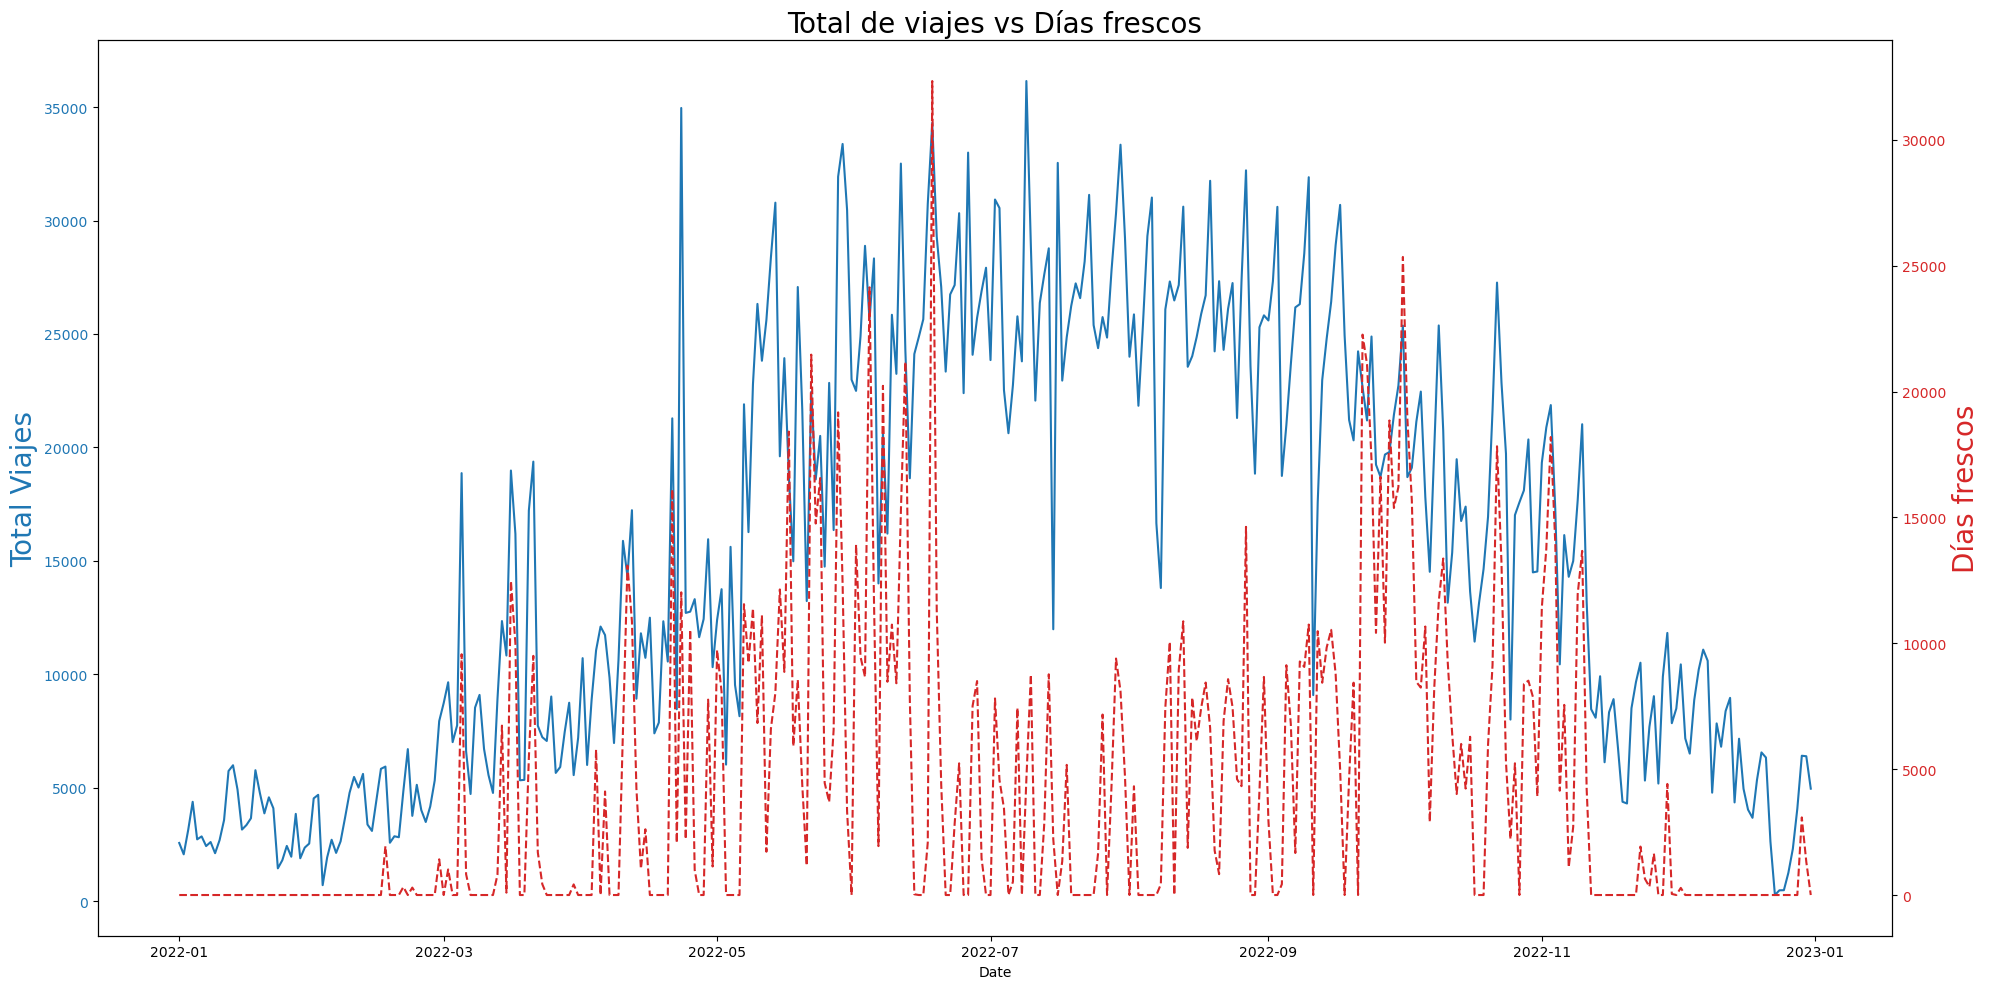

In [170]:
analisis_por_tipo_clima(5)

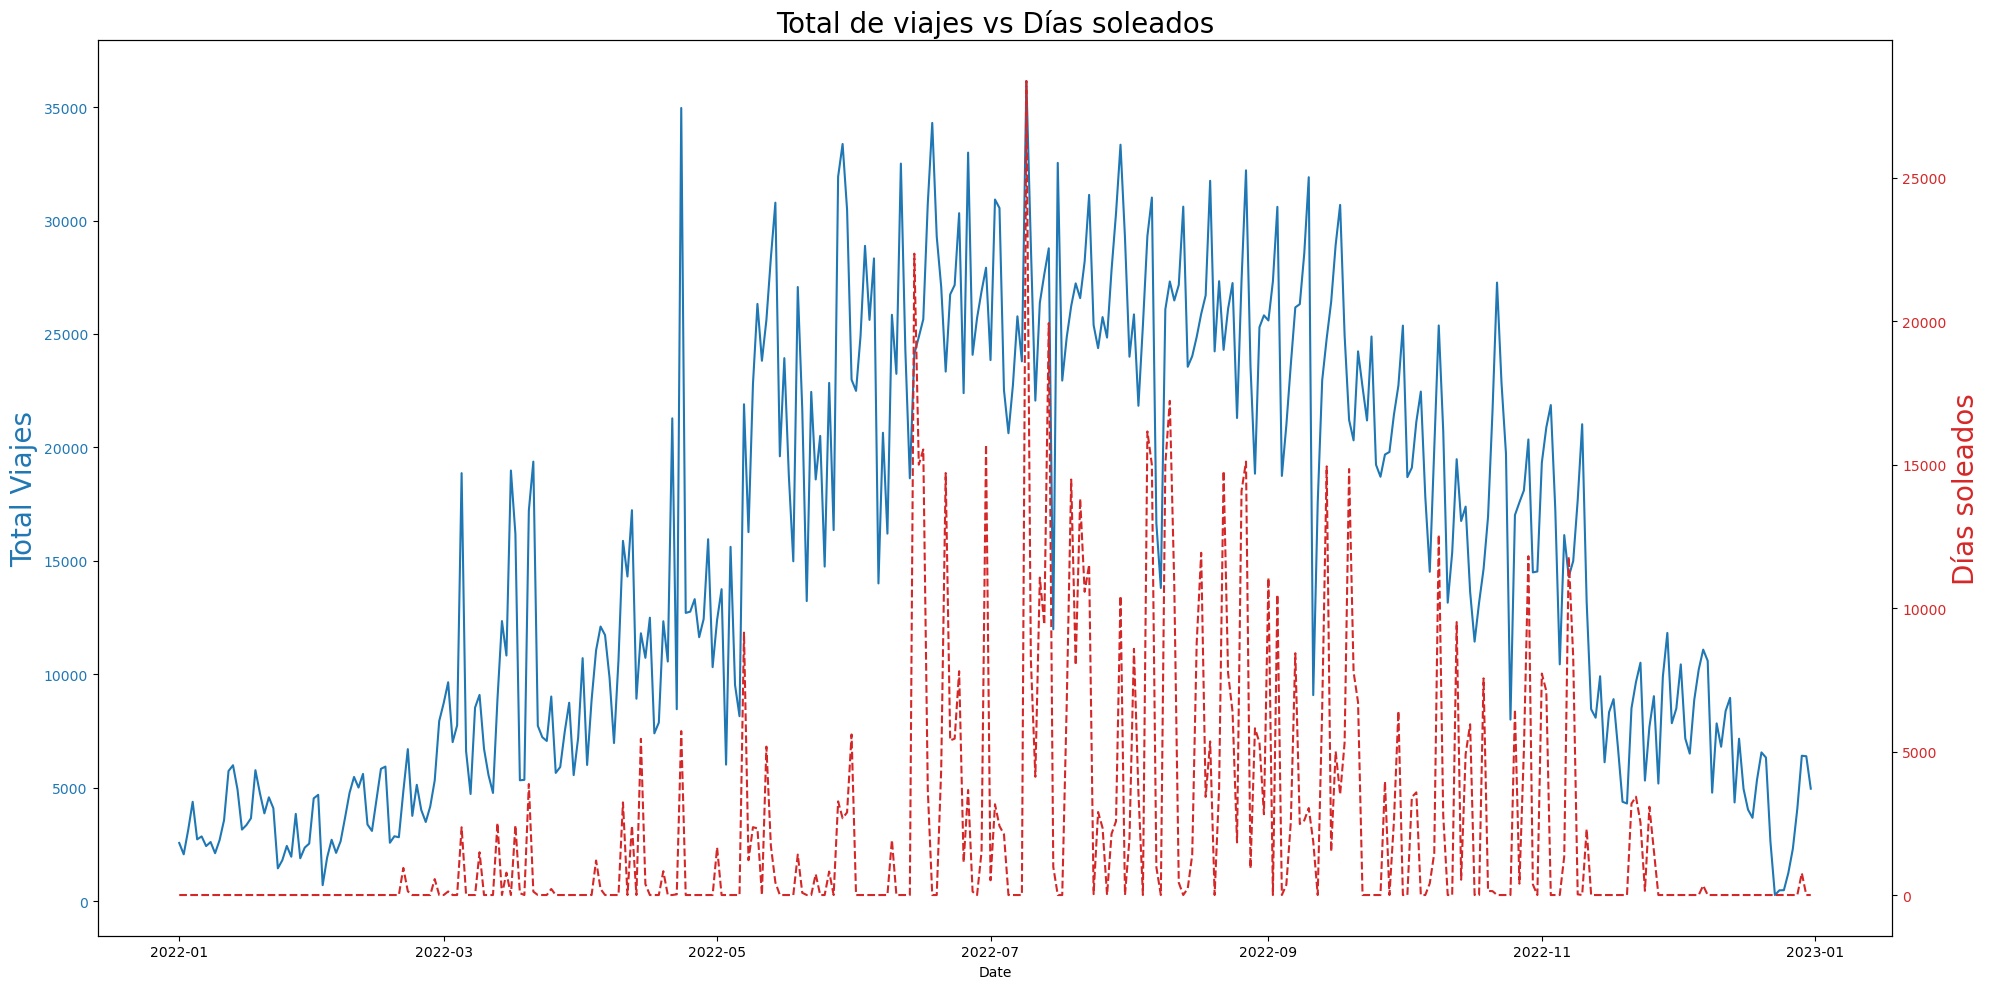

In [171]:
analisis_por_tipo_clima(6)

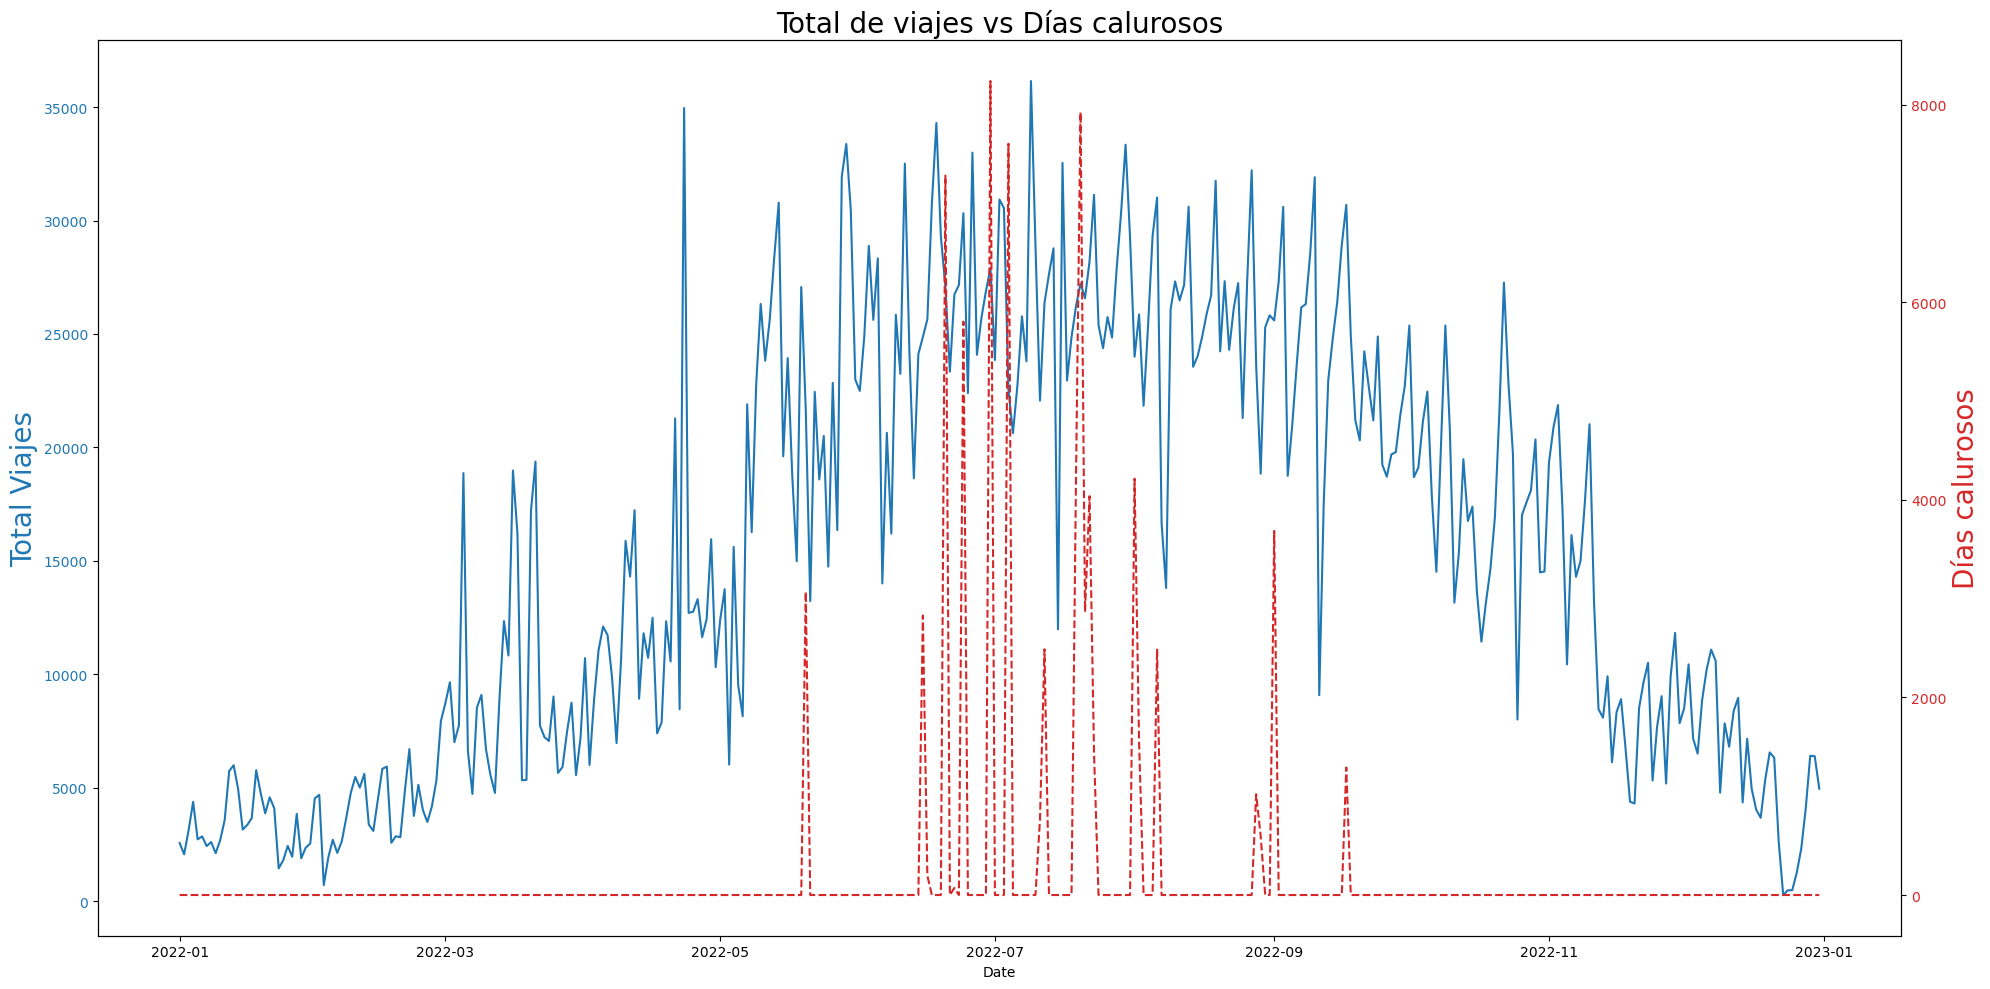

In [172]:
analisis_por_tipo_clima(7)